In [1]:
# !/usr/bin/python
# -*- coding:utf-8 -*-

import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances_argmin


# mpl.rcParams['font.sans-serif'] = [u'SimHei']
# mpl.rcParams['axes.unicode_minus'] = False

0 :	[-0.05037552 -0.13148894 -0.38291219] [ 1.49842187  1.9291459   1.91700589]
1 :	[-0.04388844 -0.09054836 -0.33142755] [ 1.49340903  1.82975771  1.78946115]
2 :	[-0.04977111 -0.06641681 -0.2963213 ] [ 1.50886798  1.75884187  1.68690716]
3 :	[-0.0609953  -0.04769542 -0.26368911] [ 1.538263    1.70214671  1.59016095]
4 :	[-0.07482219 -0.03521687 -0.23219107] [ 1.57432266  1.66288371  1.49644801]
5 :	[-0.08950239 -0.0288137  -0.20320453] [ 1.61172868  1.64025805  1.40957678]
6 :	[-0.10355931 -0.02621278 -0.17725588] [ 1.64788169  1.62928876  1.33258483]
7 :	[-0.11572301 -0.0253641  -0.15467575] [ 1.68037052  1.62507334  1.26705516]
8 :	[-0.12519729 -0.02506102 -0.13558948] [ 1.70795872  1.62492468  1.21364344]
9 :	[-0.13188589 -0.02486094 -0.11975807] [ 1.73118586  1.62816953  1.17181132]
10 :	[-0.13618991 -0.02471794 -0.10683113] [ 1.75115204  1.63457337  1.14022593]
11 :	[-0.1386616  -0.02465139 -0.09643256] [ 1.76870304  1.64356163  1.11721409]
12 :	[-0.13980974 -0.02464342 -0.08817

[0 1]
准确率：89.80%


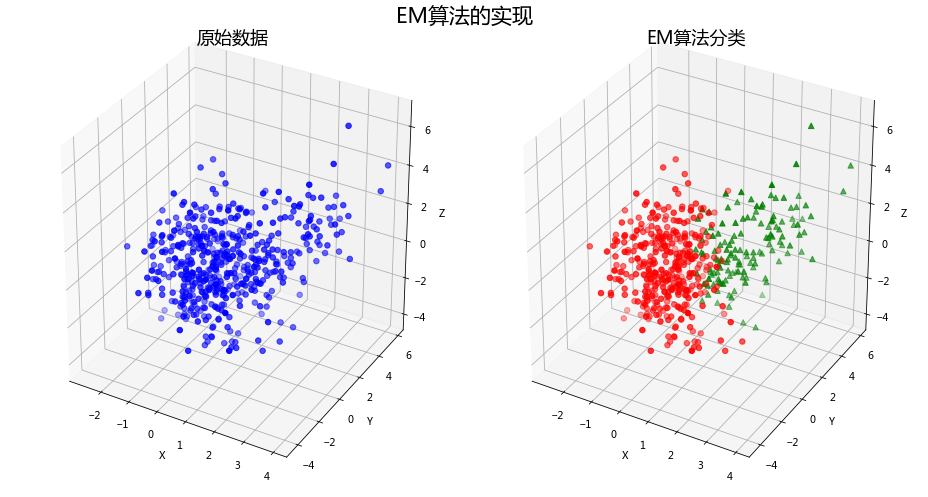

In [2]:
if __name__ == '__main__':
    style = 'myself'

    np.random.seed(0)
    mu1_fact = (0, 0, 0)
    cov1_fact = np.diag((1, 2, 3))
    data1 = np.random.multivariate_normal(mu1_fact, cov1_fact, 400)
    mu2_fact = (2, 2, 1)
    cov2_fact = np.array(((1, 1, 3), (1, 2, 1), (0, 0, 1)))
    data2 = np.random.multivariate_normal(mu2_fact, cov2_fact, 100)
    data = np.vstack((data1, data2))
    y = np.array([True] * 400 + [False] * 100)

    if style == 'sklearn':
        g = GaussianMixture(n_components=2, covariance_type='full', tol=1e-6, max_iter=1000)
        g.fit(data)
        print '类别概率:\t', g.weights_[0]
        print '均值:\n', g.means_, '\n'
        print '方差:\n', g.covariances_, '\n'
        mu1, mu2 = g.means_
        sigma1, sigma2 = g.covariances_
    else:
        num_iter = 100
        n, d = data.shape
        # 随机指定
        # mu1 = np.random.standard_normal(d)
        # print mu1
        # mu2 = np.random.standard_normal(d)
        # print mu2
        mu1 = data.min(axis=0)
        mu2 = data.max(axis=0)
        sigma1 = np.identity(d)
        sigma2 = np.identity(d)
        pi = 0.5
        # EM
        for i in range(num_iter):
            # E Step
            norm1 = multivariate_normal(mu1, sigma1)
            norm2 = multivariate_normal(mu2, sigma2)
            tau1 = pi * norm1.pdf(data)
            tau2 = (1 - pi) * norm2.pdf(data)
            gamma = tau1 / (tau1 + tau2)

            # M Step
            mu1 = np.dot(gamma, data) / np.sum(gamma)
            mu2 = np.dot((1 - gamma), data) / np.sum((1 - gamma))
            sigma1 = np.dot(gamma * (data - mu1).T, data - mu1) / np.sum(gamma)
            sigma2 = np.dot((1 - gamma) * (data - mu2).T, data - mu2) / np.sum(1 - gamma)
            pi = np.sum(gamma) / n
            print i, ":\t", mu1, mu2
        print '类别概率:\t', pi
        print '均值:\t', mu1, mu2
        print '方差:\n', sigma1, '\n\n', sigma2, '\n'

    # 预测分类
    norm1 = multivariate_normal(mu1, sigma1)
    norm2 = multivariate_normal(mu2, sigma2)
    tau1 = norm1.pdf(data)
    tau2 = norm2.pdf(data)

    fig = plt.figure(figsize=(13, 7), facecolor='w')
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', s=30, marker='o', depthshade=True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(u'原始数据', fontsize=18)
    ax = fig.add_subplot(122, projection='3d')
    order = pairwise_distances_argmin([mu1_fact, mu2_fact], [mu1, mu2], metric='euclidean')
    print order
    if order[0] == 0:
        c1 = tau1 > tau2
    else:
        c1 = tau1 < tau2
    c2 = ~c1
    acc = np.mean(y == c1)
    print u'准确率：%.2f%%' % (100*acc)
    ax.scatter(data[c1, 0], data[c1, 1], data[c1, 2], c='r', s=30, marker='o', depthshade=True)
    ax.scatter(data[c2, 0], data[c2, 1], data[c2, 2], c='g', s=30, marker='^', depthshade=True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(u'EM算法分类', fontsize=18)
    plt.suptitle(u'EM算法的实现', fontsize=21)
    plt.subplots_adjust(top=0.90)
    plt.tight_layout()
    plt.show()